In [1]:
%matplotlib notebook

In [3]:
import biff
import sys
sys.path.append('../')
import coefficients_smoothing
import pygadgetreader
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib
import jellyfish
import mwlmc_denity_shape_bfe as mshape

In [4]:
rho = mshape.load_density_grid('../rho_mwlmc_bfe.txt', 101)

In [5]:
#x_grid = np.linspace(-400, 400, 101)
#y_grid = np.linspace(-400, 400, 101)
#z_grid = np.linspace(-400, 400, 101)
x_grid, y_grid, z_grid = mshape.grid_points(101, -400, 400, dim='3d')


In [6]:
x_grid2, y_grid2 = mshape.grid_points(101, -400, 400, dim='2d')


<IPython.core.display.Javascript object>


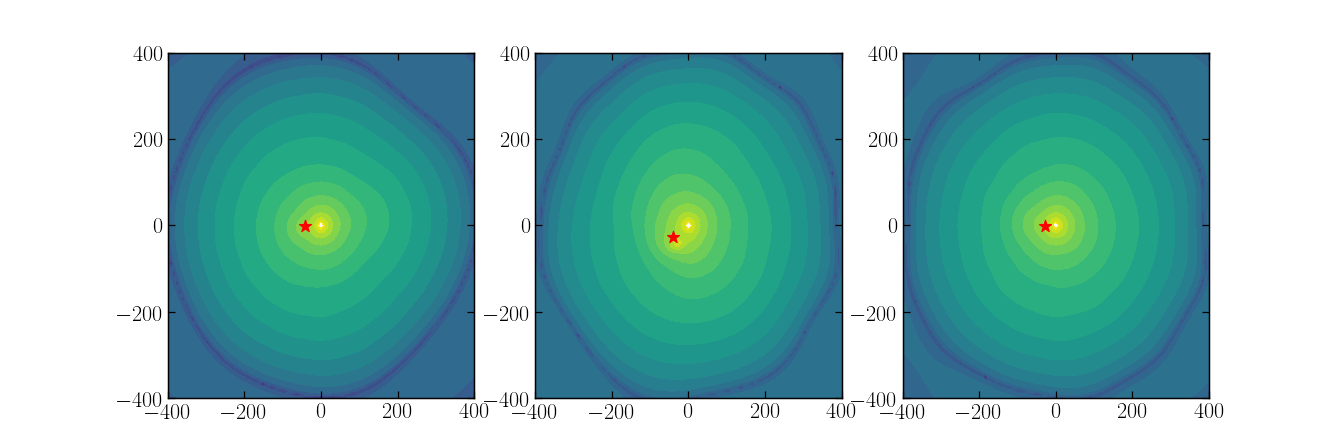

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))

## y-x
ax[0].contourf(x_grid2, y_grid2, np.log10(np.abs(rho[:,:,50])), 20)
ax[0].scatter(-41, -1, marker='*', c='r', s=100)

## y-z
ax[1].contourf(x_grid2, y_grid2, np.log10(np.abs(rho[50,:,:])), 20)
ax[1].scatter(-41, -28, marker='*', c='r', s=100)

## x-z
ax[2].contourf(x_grid2, y_grid2, np.log10(np.abs(rho[:,50,:])), 20)
ax[2].scatter(-28, -1, marker='*', c='r', s=100)

<IPython.core.display.Javascript object>


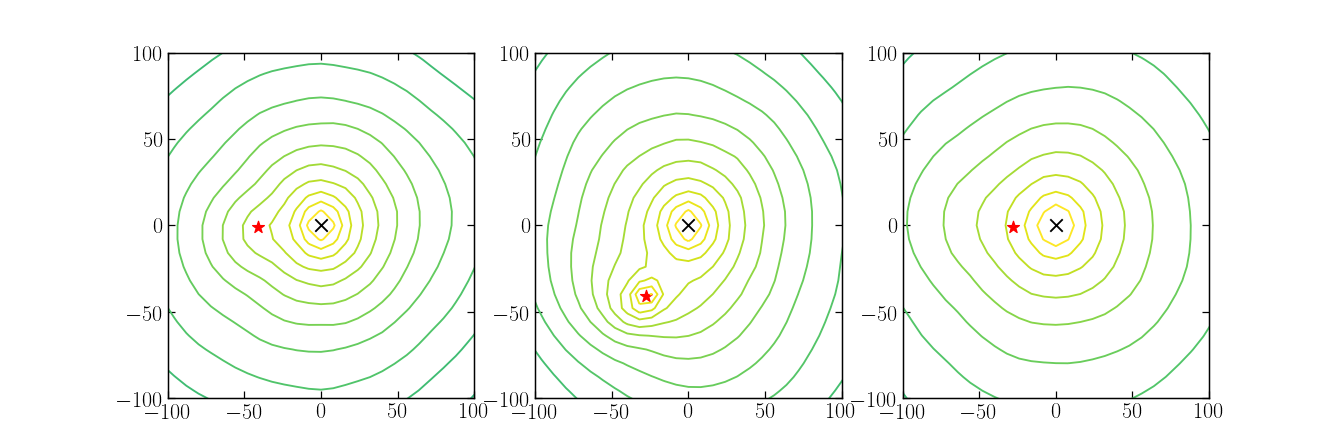

(-100, 100)

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))

## y-x
ax[0].contour(x_grid2, y_grid2, np.log10(np.abs(rho[:,:,50])), 30)
ax[0].scatter(-41, -1, marker='*', c='r', s=100)
ax[0].scatter(0, 0, marker='x', c='k', s=100)
ax[0].set_xlim(-100, 100)
ax[0].set_ylim(-100, 100)

## y-z
ax[1].contour(x_grid2, y_grid2, np.log10(np.abs(rho[50,:,:])), 30)
ax[1].scatter(-28, -41, marker='*', c='r', s=100)
ax[1].scatter(0, 0, marker='x', c='k', s=100)
ax[1].set_xlim(-100, 100)
ax[1].set_ylim(-100, 100)
## x-z
ax[2].contour(x_grid2, y_grid2, np.log10(np.abs(rho[:,50,:])), 30)
ax[2].scatter(-28, -1, marker='*', c='r', s=100)
ax[2].scatter(0, 0, marker='x', c='k', s=100)
ax[2].set_xlim(-100, 100)
ax[2].set_ylim(-100, 100)


In [162]:
def plot_elli_fit(xgrid, ygrid, zgrid, pos_elli):
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_aspect('equal')
    r_shell = int(np.median(np.sqrt(pos_elli[:,:,0]**2 + pos_elli[:,:,1]**2 + pos_elli[:,:,2]**2)))
    ax.set_title('{} kpc'.format(r_shell))
    ax.scatter(xgrid, ygrid, zgrid, marker='.', color='k', s=2, 
               alpha=0.7)
    ax.plot_wireframe(pos_elli[:,:,0], pos_elli[:,:,1], pos_elli[:,:,2], rstride=4, cstride=4, color='r', alpha=0.5)
    return r_shell


def twod_fits_plot(xgrid, ygrid, zgrid, xgrid_fit, ygrid_fit, zgrid_fit):
    x_data1, y_data1 = jellyfish.shapes.twod_surface(xgrid, ygrid)
    x_data2, y_data2 = jellyfish.shapes.twod_surface(xgrid, zgrid)
    y_data3, z_data3 = jellyfish.shapes.twod_surface(ygrid, zgrid)
    
    x_fit1, y_fit1 = jellyfish.shapes.twod_surface(xgrid_fit, ygrid_fit)
    x_fit2, y_fit2 = jellyfish.shapes.twod_surface(xgrid_fit, zgrid_fit)
    y_fit3, z_fit3 = jellyfish.shapes.twod_surface(ygrid_fit, zgrid_fit)
    
    return [x_data1, y_data1, x_data2, y_data2, y_data3, z_data3], [x_fit1, y_fit1, x_fit2, y_fit2, y_fit3, z_fit3]

def likelihood(pos, axis):
    
    
    
    
    assert np.shape(pos)[-1] == 3, 'Error with the dimensions of the positions array axis[-1]=3'
    a = axis[0]
    b = axis[1]
    c = axis[2]
    assert a>=b>=c, 'Error: Check order of axis lengths'
    fit = pos[:,0]**2/a**2 + pos[:,1]**2/b**2 + pos[:,2]**2/c**2
    chi2 = np.sum(1 - fit)**2
    L = - 0.5 * chi2
    return chi2


In [146]:
rho_contours, r_ell, N_dots_r = mshape.compute_density_contour(rho, 45, x_grid, y_grid, z_grid)

/home/xzk/work/github/MW-LMC-SCF/code/halo_shape/mwlmc_denity_shape_bfe.py:81: RuntimeWarning: invalid value encountered in greater_equal
  index_dens =  np.where((np.log10(np.abs(dens))>=contours[i] - delta_rho_low)
/home/xzk/work/github/MW-LMC-SCF/code/halo_shape/mwlmc_denity_shape_bfe.py:82: RuntimeWarning: invalid value encountered in less_equal
  & (np.log10(np.abs(dens))<=contours[i] + delta_rho_high))


In [147]:
print(len(r_ell), r_ell)

12 [262.541425302751, 236.5079279855117, 208.153789300123, 177.62882648939615, 149.02348808157726, 125.47509713086498, 105.52724766618336, 88.36288813749809, 72.8834686331544, 58.787753826796276, 47.32863826479693, 37.52332607858744]


In [148]:
N_dots_r

[42188, 37459, 31752, 23739, 14074, 7891, 4872, 3110, 1789, 1046, 603, 341]

<IPython.core.display.Javascript object>


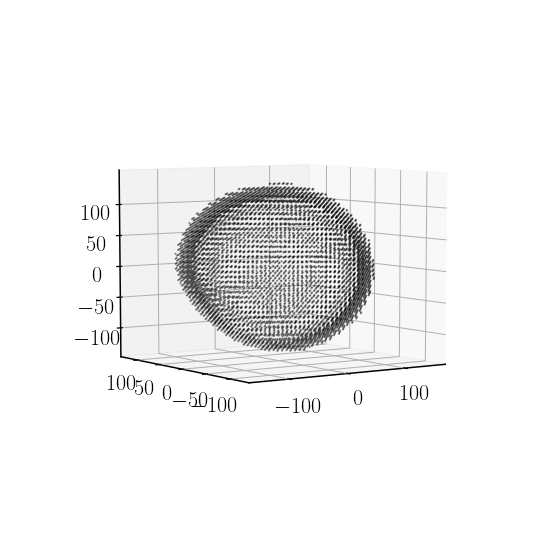

In [228]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')

#hack  for equal axes
ax.set_aspect('equal')
ax.scatter(x_grid[rho_contours[5]], y_grid[rho_contours[5]]
           , z_grid[rho_contours[5]], marker='.', color='k', s=2, alpha=0.4)
#ax.set_xlim(-60, 60)
#ax.set_ylim(-60, 60)
#ax.set_zlim(-60, 60)

In [150]:
n_contours = len(r_ell)
eigves = np.zeros((n_contours ,3, 3))
axis = np.zeros((n_contours ,3))
s = np.zeros(n_contours)
q = np.zeros(n_contours)
pos_ell = []

for i in range(len(r_ell)):
    print(i)
    eigves[i], axis[i], s[i], q[i] = mshape.compute_halo_shape(rho_contours[i], x_grid, y_grid, z_grid)
    pos_elli = jellyfish.ellipse_3dcartesian(axis[i], eigves[i])
    pos_ell.append(pos_elli)

0
1
2


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  # Remove the CWD from sys.path while we load stuff.


3
4
5
6
7
8
9
10
11


<IPython.core.display.Javascript object>


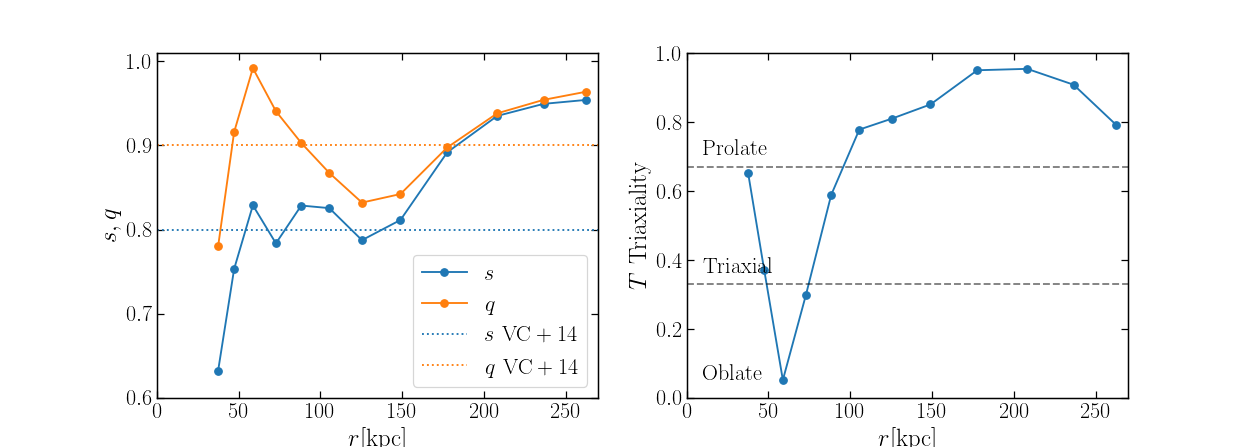

In [555]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].plot(r_ell, s, '-o', label='$s$')
ax[0].plot(r_ell, q, '-o', label='$q$')

ax[0].axhline(0.8, label=r'$s\ \rm{VC+14}$', c='C0', ls=':')
ax[0].axhline(0.9, label=r'$q\ \rm{VC+14}$', c='C1', ls=':')

ax[0].set_ylim(0.6, 1.01)
ax[0].set_xlim(0, 270)
ax[0].legend()
ax[0].set_xlabel(r'$r\rm{[kpc]}$')
ax[0].set_ylabel(r'$s, q$')


ax[1].plot(r_ell, (1-q**2)/(1-s**2), '-o')
ax[1].axhline(0.67, c='k', ls='--', alpha=0.5)
ax[1].axhline(0.33, c='k', ls='--', alpha=0.5)
ax[1].text(10, 0.05, r'$\rm{Oblate}$')
ax[1].text(10, 0.36, r'$\rm{Triaxial}$')
ax[1].text(10, 0.7, r'$\rm{Prolate}$')
ax[1].set_ylim(0, 1)
ax[1].set_xlim(0, 270)
ax[1].set_xlabel(r'$r\rm{[kpc]}$')
ax[1].set_ylabel(r'$T\ \rm{Triaxiality}$')


plt.savefig('shape_mwlmc5_vera_ciro.pdf', bbox_inches='tight')

<IPython.core.display.Javascript object>


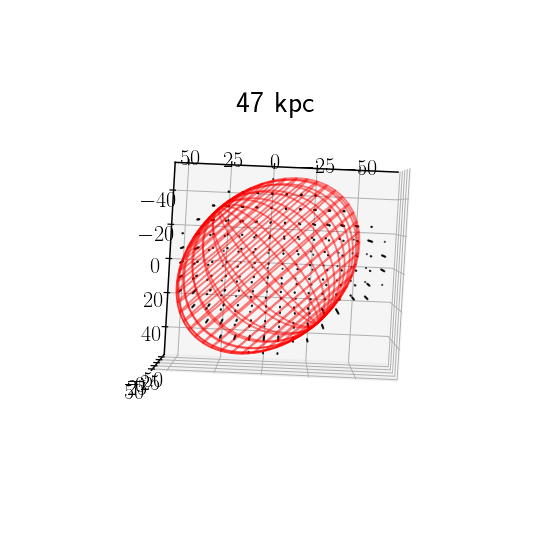

In [305]:
r_s_3 = plot_elli_fit(x_grid[rho_contours[10]], y_grid[rho_contours[10]], z_grid[rho_contours[10]], pos_ell[10])


In [153]:
data_2d_all = []
fit_2d_all = []
for i in range(n_contours):
    data_2d, fit_2d = twod_fits_plot(x_grid[rho_contours[i]].flatten(), y_grid[rho_contours[i]].flatten(),
                                           z_grid[rho_contours[i]].flatten(), pos_ell[i][:,:,0].flatten(), 
                                           pos_ell[i][:,:,1].flatten(), pos_ell[i][:,:,2].flatten())
    data_2d_all.append(data_2d)
    fit_2d_all.append(fit_2d)

In [154]:
len(data_2d_all)

12

In [540]:
col = plt.cm.plasma_r(np.linspace(0, 1, n_contours))    

<IPython.core.display.Javascript object>


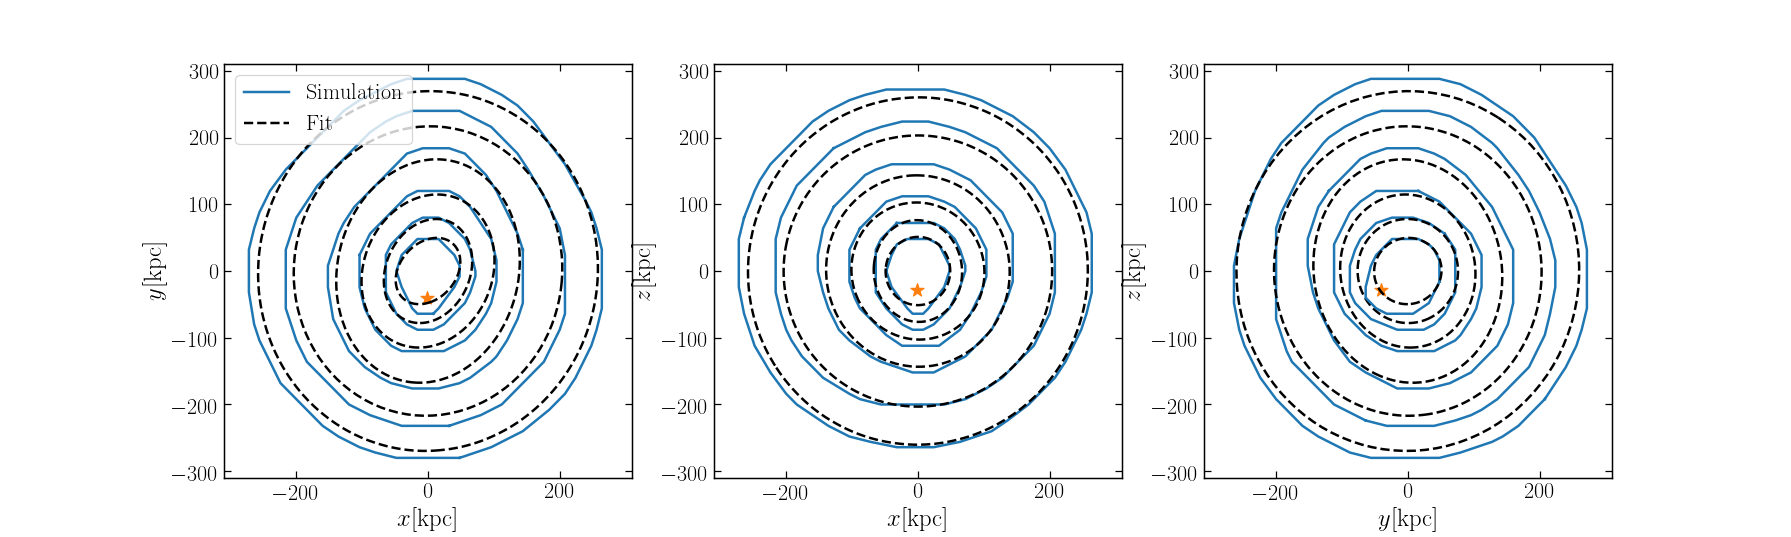

In [549]:
fig, ax = plt.subplots(1, 3, figsize=(20,6))

for i in range(0,len(data_2d_all),2):
    if i==0:
        ax[0].plot(data_2d_all[i][1], data_2d_all[i][0], lw=2, label=r'$\rm{Simulation}$',  c='C0')
        ax[0].plot(fit_2d_all[i][1], fit_2d_all[i][0], lw=2, label=r'$\rm{Fit}$', ls='--', c='k')

    elif i>0:
        ax[0].plot(data_2d_all[i][1], data_2d_all[i][0], lw=2, c='C0')
        ax[0].plot(fit_2d_all[i][1], fit_2d_all[i][0], lw=2, ls='--', c='k')

ax[0].set_xlim(-310, 310)
ax[0].set_ylim(-310, 310)

ax[0].legend()


for i in range(0, len(data_2d_all), 2):
    ax[1].plot(data_2d_all[i][4], data_2d_all[i][5], lw=2, c='C0')
    ax[1].plot(fit_2d_all[i][4], fit_2d_all[i][5], lw=2, ls='--', c='k')

ax[1].set_xlim(-310, 310)
ax[1].set_ylim(-310, 310)    

for i in range(0, len(data_2d_all), 2):
    ax[2].plot(data_2d_all[i][3], data_2d_all[i][2], lw=2, c='C0')
    ax[2].plot(fit_2d_all[i][3], fit_2d_all[i][2], lw=2, ls='--', c='k')

ax[2].set_xlim(-310, 310)
ax[2].set_ylim(-310, 310)

ax[2].set_xlabel(r'$y\rm{[kpc]$')
ax[2].set_ylabel(r'$z\rm{[kpc]$')


ax[1].set_xlabel(r'$x\rm{[kpc]$')
ax[1].set_ylabel(r'$z\rm{[kpc]$')


ax[0].set_ylabel(r'$y\rm{[kpc]$')
ax[0].set_xlabel(r'$x\rm{[kpc]$')


ax[0].scatter(-1, -41, marker='*', s=120, c='C1')
ax[2].scatter(-41, -28, marker='*', s=120, c='C1')
ax[1].scatter(-1, -28, marker='*', s=120, c='C1')

plt.savefig('MWLMC5_shape_dens_contours.pdf', bbox_inches='tight')

<IPython.core.display.Javascript object>


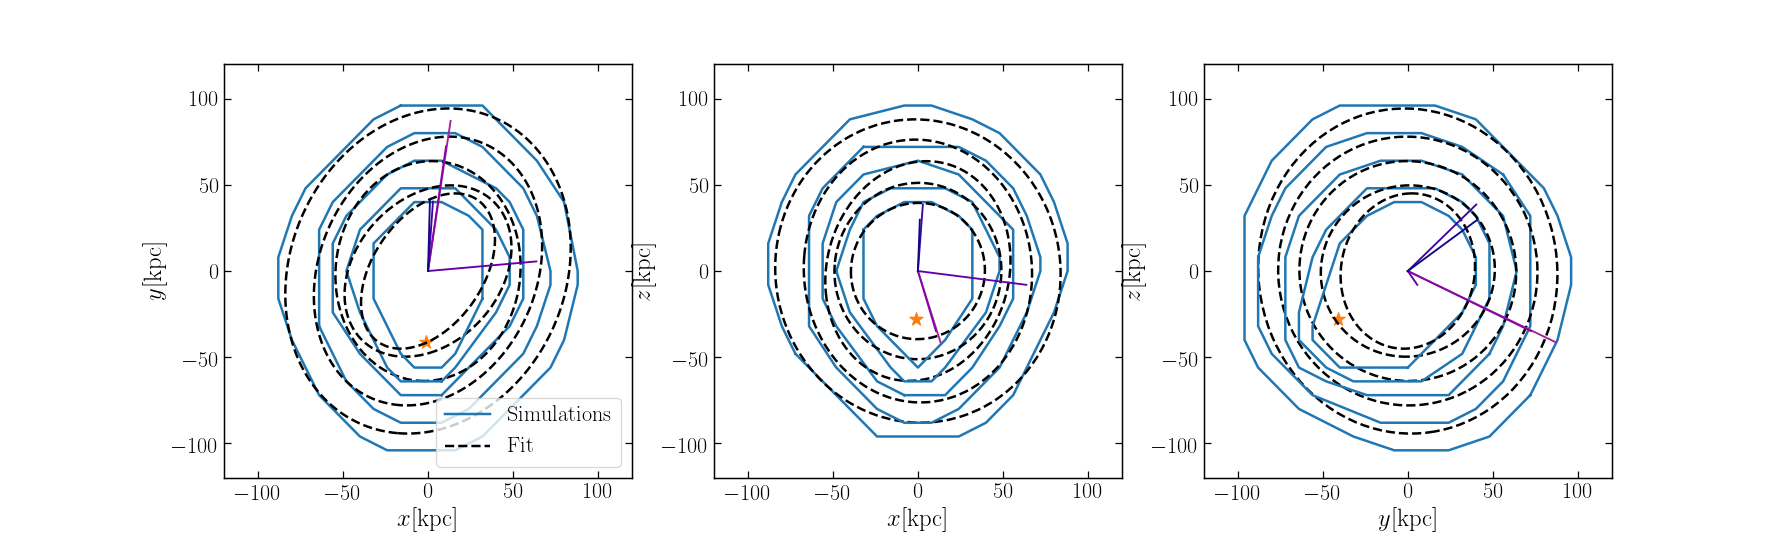

In [550]:
fig, ax = plt.subplots(1, 3, figsize=(20,6))

init_i = 7
for i in range(init_i,len(data_2d_all)):
    if i==7:
        ax[0].plot(data_2d_all[i][1], data_2d_all[i][0], label=r'$\rm{Simulations}$', lw=2, c='C0')
        ax[0].plot(fit_2d_all[i][1], fit_2d_all[i][0], lw=2, label=r'$\rm{Fit}$', ls='--', c='k')

    elif i!=7:
        ax[0].plot(data_2d_all[i][1], data_2d_all[i][0], lw=2, c='C0')
        ax[0].plot(fit_2d_all[i][1], fit_2d_all[i][0], lw=2, ls='--', c='k')

ax[0].set_xlim(-120, 120)
ax[0].set_ylim(-120, 120)

ax[0].legend()


for i in range(init_i, len(data_2d_all)):
    ax[1].plot(data_2d_all[i][4], data_2d_all[i][5], lw=2, c='C0')
    ax[1].plot(fit_2d_all[i][4], fit_2d_all[i][5], lw=2, ls='--', c='k')

ax[1].set_xlim(-120, 120)
ax[1].set_ylim(-120, 120)

for i in range(init_i, len(data_2d_all)):
    ax[2].plot(data_2d_all[i][3], data_2d_all[i][2], lw=2, c='C0')
    ax[2].plot(fit_2d_all[i][3], fit_2d_all[i][2], lw=2, ls='--', c='k')


for i in range(init_i,n_contours):
    ax[0].plot([0,x_pa[i]], [0,y_pa[i]], c=col[i])
    ax[1].plot([0,x_pa[i]], [0,z_pa[i]], c=col[i])
    ax[2].plot([0,y_pa[i]], [0,z_pa[i]], c=col[i])
    
ax[2].set_xlim(-120, 120)
ax[2].set_ylim(-120, 120)

ax[2].set_xlabel(r'$y\rm{[kpc]$')
ax[2].set_ylabel(r'$z\rm{[kpc]$')


ax[1].set_xlabel(r'$x\rm{[kpc]$')
ax[1].set_ylabel(r'$z\rm{[kpc]$')


ax[0].set_ylabel(r'$y\rm{[kpc]$')
ax[0].set_xlabel(r'$x\rm{[kpc]$')


ax[0].scatter(-1, -41, marker='*', s=120, c='C1')
ax[2].scatter(-41, -28, marker='*', s=120, c='C1')
ax[1].scatter(-1, -28, marker='*', s=120, c='C1')

plt.savefig('MWLMC5_shape_dens_contours_inner_100.pdf', bbox_inches='tight')

## Principal axis angle:

In [391]:
x_pa = np.zeros(n_contours)
y_pa = np.zeros(n_contours)
z_pa = np.zeros(n_contours)

for i in range(n_contours):
    y_pa[i], x_pa[i], z_pa[i] = eigves[i][:,0]*axis[i][0]
    

In [393]:
for i in range(n_contours):
    print(eigves[i][:,0])

[0.98140297 0.11347277 0.15482936]
[0.98273496 0.11564008 0.14442777]
[0.9897958  0.11054393 0.08991286]
[ 0.98960616 -0.06097297  0.130238  ]
[ 0.96162639  0.14029591 -0.23577902]
[ 0.9301489   0.14413682 -0.33770933]
[ 0.90537474  0.15055743 -0.39702525]
[ 0.89479688  0.13650455 -0.42509416]
[ 0.89325277  0.13070472 -0.4301346 ]
[ 0.08644433  0.98848952 -0.12416057]
[0.7208782  0.05222084 0.6910916 ]
[0.80859242 0.02226026 0.58794794]


<IPython.core.display.Javascript object>


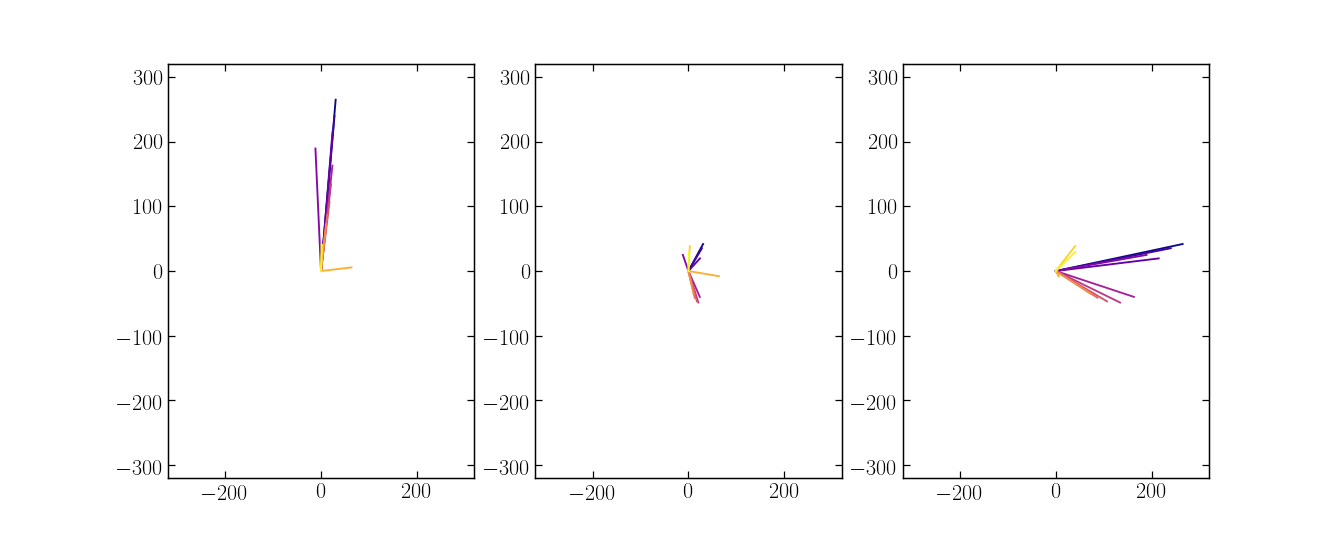

(-320, 320)

In [417]:


ax[0].set_xlim(-320, 320)
ax[0].set_ylim(-320, 320)

ax[1].set_xlim(-320, 320)
ax[1].set_ylim(-320, 320)

ax[2].set_xlim(-320, 320)
ax[2].set_ylim(-320, 320)

#fig.colorbar()

In [429]:
# transformation to Galactic coordinates
from astropy.coordinates import SkyCoord
from astropy import units as u



In [430]:
def cart_galactic(pos):
    c_gal = SkyCoord(pos, representation='cartesian', frame='galactic')
    c_gal.representation = 'spherical'

    ## to degrees and wrapping l

    l_degrees = c_gal.l.wrap_at(180 * u.deg).radian
    b_degrees = c_gal.b.radian

    return l_degrees, b_degrees

In [507]:
l_pa, b_pa = cart_galactic(np.array([x_pa, y_pa, z_pa]).T)
l_lmc, b_lmc = cart_galactic(np.array([[-1], [-41], [-28]]))

<IPython.core.display.Javascript object>


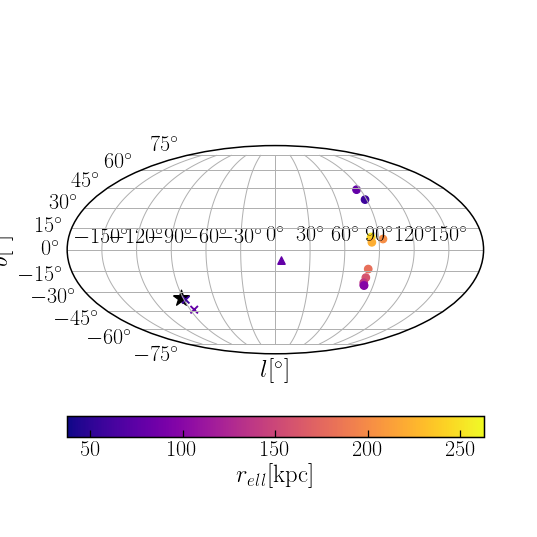

In [542]:
fig = plt.figure(figsize=(6,6))
plt.subplot(111, projection='mollweide')

plt.scatter(l_lmc, b_lmc, marker='*', c='k', s=180, label=r'$\rm{LMC}$')
plt.scatter(l_pa[:-3], b_pa[:-3], c=col[:-3])
plt.scatter(l_pa[-2:], b_pa[-2:], marker='o', c=col[-3:])

plt.scatter(-l_pa[-2:], -b_pa[-2:], marker='x', c=col[-3:])
plt.scatter(l_pa[-3], b_pa[-3], marker='^', c=col[-3])


plt.grid()
plt.xlabel('$l[^{\circ}]$')
plt.ylabel('$b[^{\circ}]$')

sm = plt.cm.ScalarMappable(cmap=matplotlib.cm.plasma)
sm.set_array(np.linspace(np.min(r_ell), np.max(r_ell)))
cbar = plt.colorbar(sm, orientation='horizontal')
cbar.set_label(r'$r_{ell}\rm{[kpc]}$')

plt.savefig('principal_axis_galactic_mollweide.pdf', bbox_inches='tight')

## Likeihood 

In [318]:
L_r = np.zeros(len(s))
for i in range(len(s)):
    L_r[i] = likelihood(np.array([x_grid[rho_contours[i]], y_grid[rho_contours[i]], z_grid[rho_contours[i]]]).T, axis[i])

<IPython.core.display.Javascript object>


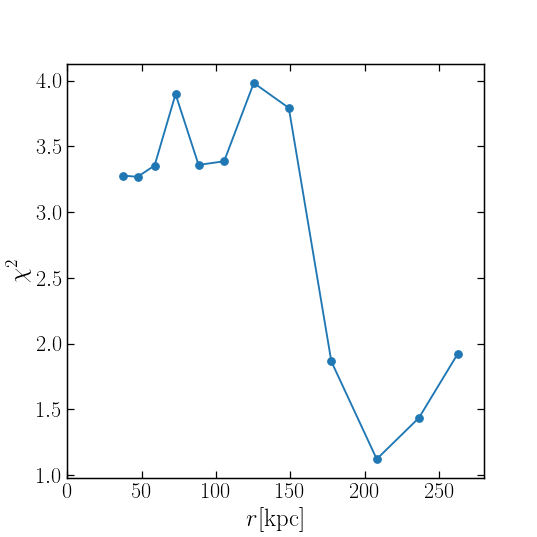

(0, 280)

In [557]:
plt.figure(figsize=(6,6))
plt.plot(r_ell, np.log10(L_r), '-o')
plt.xlabel(r'$r\rm{[kpc]}$')
plt.ylabel(r'$\chi^2$')
plt.xlim(0, 280)

In [368]:
n_cont = 4
data = np.array([x_grid[rho_contours[n_cont]], y_grid[rho_contours[n_cont]], z_grid[rho_contours[n_cont]]])
eigves_inv = np.linalg.inv(eigves[n_cont])
data_inv = np.dot(data.T, eigves_inv)


u = np.linspace(0.0, 2.0 * np.pi, 100)
v = np.linspace(0.0, np.pi, 100)

# cartesian coordinates that correspond to the spherical
# angles:
x = axis[n_cont][0] * np.outer(np.cos(u), np.sin(v))
y = axis[n_cont][1] * np.outer(np.sin(u), np.sin(v))
z = axis[n_cont][2] * np.outer(np.ones_like(u), np.cos(v))
xyz_inv = np.array([x, y, z]).T

<IPython.core.display.Javascript object>


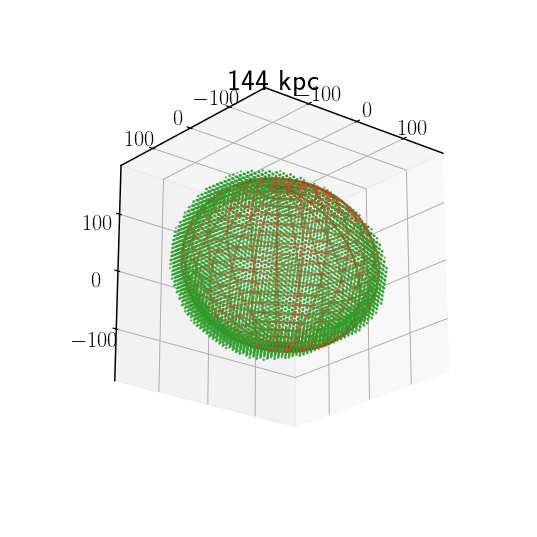

(-180, 180)

In [369]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.set_aspect('equal')
r_shell = int(np.median(np.sqrt(xyz_inv[:,:,0]**2 + xyz_inv[:,:,1]**2 + xyz_inv[:,:,2]**2)))
ax.set_title('{} kpc'.format(r_shell))

ax.plot_wireframe(xyz_inv[:,:,0], xyz_inv[:,:,1], xyz_inv[:,:,2], rstride=4, cstride=4, color='r', alpha=0.5)
ax.scatter(data_inv[:,0], data_inv[:,1], data_inv[:,2], color='C2', alpha=0.5, s=1)
ax.set_xlim(-180, 180)
ax.set_ylim(-180, 180)
ax.set_zlim(-180, 180)



<IPython.core.display.Javascript object>


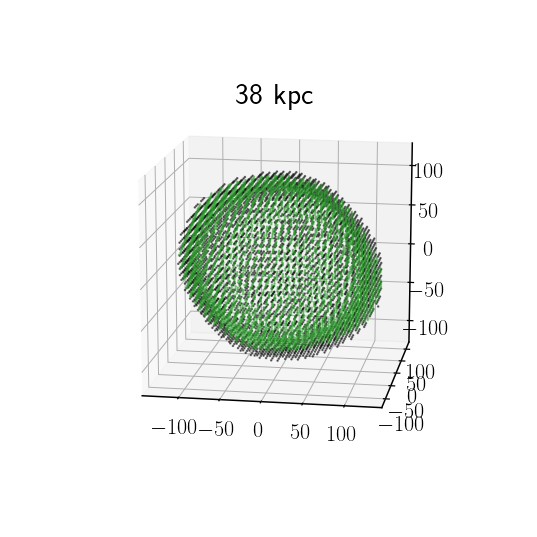

In [356]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.set_aspect('equal')
r_shell = int(np.median(np.sqrt(pos_elli[:,:,0]**2 + pos_elli[:,:,1]**2 + pos_elli[:,:,2]**2)))
ax.set_title('{} kpc'.format(r_shell))

ax.scatter(data[0], data[1], data[2], color='k', alpha=0.5, s=1)
ax.scatter(data_inv[:,0], data_inv[:,1], data_inv[:,2], color='C2', alpha=0.5, s=1)

In [360]:
L_r_inv = np.zeros(len(s))
for i in range(len(s)):
    data = np.array([x_grid[rho_contours[i]], y_grid[rho_contours[i]], z_grid[rho_contours[i]]])
    eigves_inv = np.linalg.inv(eigves[i])
    data_inv = np.dot(data.T, eigves_inv)

    L_r_inv[i] = likelihood(data_inv, axis[i])

In [365]:
r_ell

[262.541425302751,
 236.5079279855117,
 208.153789300123,
 177.62882648939615,
 149.02348808157726,
 125.47509713086498,
 105.52724766618336,
 88.36288813749809,
 72.8834686331544,
 58.787753826796276,
 47.32863826479693,
 37.52332607858744]

In [366]:
L_r_inv

array([6.27083986e-01, 1.05660205e+00, 1.69304175e+01, 1.48523581e-04,
       9.39933749e+01, 1.24025720e+03, 5.12636002e+02, 2.64351305e+02,
       2.10526174e+02, 3.54829918e+01, 5.27882308e+02, 8.46814609e+02])

<IPython.core.display.Javascript object>


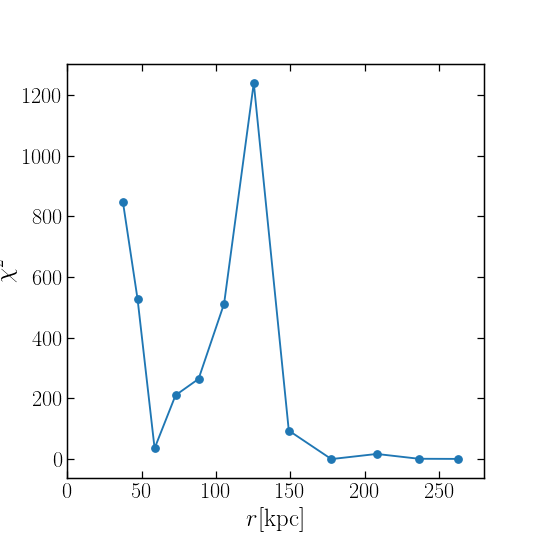

(0, 280)

In [362]:
plt.figure(figsize=(6,6))
#plt.plot(r_ell, (L_r), '-o')
plt.plot(r_ell, (L_r_inv), '-o')

plt.xlabel(r'$r\rm{[kpc]}$')
plt.ylabel(r'$\chi^2$')
plt.xlim(0, 280)

<IPython.core.display.Javascript object>


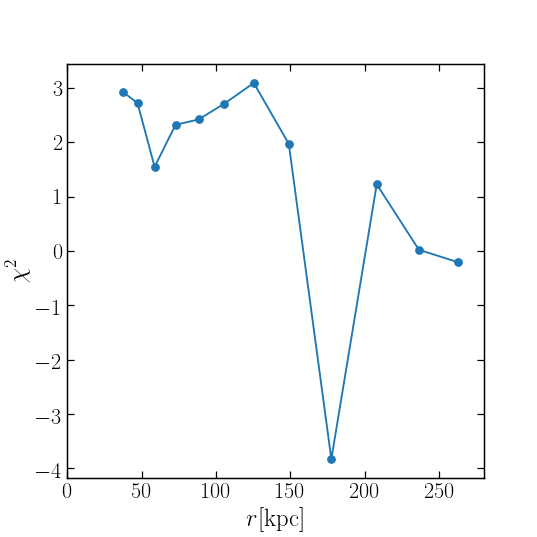

(0, 280)

In [367]:
plt.figure(figsize=(6,6))
#plt.plot(r_ell, (L_r), '-o')
plt.plot(r_ell, np.log10(L_r_inv), '-o')

plt.xlabel(r'$r\rm{[kpc]}$')
plt.ylabel(r'$\chi^2$')
plt.xlim(0, 280)